In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 11.1MB/s 


In [ ]:
from pathlib import Path

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image, ImageFile
from tensorboardX import SummaryWriter
from torchvision import transforms
from tqdm import tqdm


cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
# Disable OSError: image file is truncated
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls drive/'My Drive'/models

decoder_iter_100000.pth.tar  decoder_iter_48000.pth.tar
decoder_iter_10000.pth.tar   decoder_iter_50000.pth.tar
decoder_iter_102000.pth.tar  decoder_iter_52000.pth.tar
decoder_iter_104000.pth.tar  decoder_iter_54000.pth.tar
decoder_iter_106000.pth.tar  decoder_iter_56000.pth.tar
decoder_iter_108000.pth.tar  decoder_iter_58000.pth.tar
decoder_iter_110000.pth.tar  decoder_iter_60000.pth.tar
decoder_iter_112000.pth.tar  decoder_iter_6000.pth.tar
decoder_iter_114000.pth.tar  decoder_iter_62000.pth.tar
decoder_iter_116000.pth.tar  decoder_iter_64000.pth.tar
decoder_iter_12000.pth.tar   decoder_iter_66000.pth.tar
decoder_iter_14000.pth.tar   decoder_iter_68000.pth.tar
decoder_iter_16000.pth.tar   decoder_iter_70000.pth.tar
decoder_iter_18000.pth.tar   decoder_iter_72000.pth.tar
decoder_iter_20000.pth.tar   decoder_iter_74000.pth.tar
decoder_iter_2000.pth.tar    decoder_iter_76000.pth.tar
decoder_iter_22000.pth.tar   decoder_iter_78000.pth.tar
decoder_iter_24000.pth.tar   decoder_iter_80000.p

In [ ]:
content_dir = "/content/drive/My Drive/content"
style_dir = "/content/drive/My Drive/style"
decoder_path = None
decoder_path = "/content/drive/My Drive/models/decoder_iter_74000.pth.tar"
training_iters_passed = 74000
vgg_path = "/content/drive/My Drive/models/vgg_normalised.pth"
save_dir = '/content/drive/My Drive/models'
log_dir = './logs'
lr = 1e-4
lr_decay = 5e-5
max_iter = 160000
batch_size = 8
style_weight = 10.0
content_weight = 1.0
n_threads = 8
save_model_interval = 2000

In [ ]:
def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)


class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'


def adjust_learning_rate(optimizer, lr, iteration_count):
    """Imitating the original implementation"""
    lr = lr / (1.0 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)


class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s


def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

In [ ]:
save_dir = Path(save_dir)
save_dir.mkdir(exist_ok=True, parents=True)
log_dir = Path(log_dir)
log_dir.mkdir(exist_ok=True, parents=True)
writer = SummaryWriter(log_dir=str(log_dir))

In [ ]:
decoder = decoder
vgg = vgg
if decoder_path is not None:
  decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))
vgg = nn.Sequential(*list(vgg.children())[:31])
network = Net(vgg, decoder)
network.train()
network.to(device)

Net(
  (enc_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (enc_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (enc_4): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(256, 256,

In [ ]:
content_tf = train_transform()
style_tf = train_transform()

content_dataset = FlatFolderDataset(content_dir, content_tf)
style_dataset = FlatFolderDataset(style_dir, style_tf)

content_iter = iter(data.DataLoader(
    content_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=n_threads))
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=n_threads))

In [ ]:
!ls ./drive/'My Drive'/models/

decoder_iter_100000.pth.tar  decoder_iter_48000.pth.tar
decoder_iter_10000.pth.tar   decoder_iter_50000.pth.tar
decoder_iter_102000.pth.tar  decoder_iter_52000.pth.tar
decoder_iter_104000.pth.tar  decoder_iter_54000.pth.tar
decoder_iter_106000.pth.tar  decoder_iter_56000.pth.tar
decoder_iter_108000.pth.tar  decoder_iter_58000.pth.tar
decoder_iter_110000.pth.tar  decoder_iter_60000.pth.tar
decoder_iter_112000.pth.tar  decoder_iter_6000.pth.tar
decoder_iter_114000.pth.tar  decoder_iter_62000.pth.tar
decoder_iter_116000.pth.tar  decoder_iter_64000.pth.tar
decoder_iter_12000.pth.tar   decoder_iter_66000.pth.tar
decoder_iter_14000.pth.tar   decoder_iter_68000.pth.tar
decoder_iter_16000.pth.tar   decoder_iter_70000.pth.tar
decoder_iter_18000.pth.tar   decoder_iter_72000.pth.tar
decoder_iter_20000.pth.tar   decoder_iter_74000.pth.tar
decoder_iter_2000.pth.tar    decoder_iter_76000.pth.tar
decoder_iter_22000.pth.tar   decoder_iter_78000.pth.tar
decoder_iter_24000.pth.tar   decoder_iter_80000.p

In [ ]:
optimizer = torch.optim.Adam(network.decoder.parameters(), lr=lr)

for i in tqdm(range(max_iter)):
    adjust_learning_rate(optimizer, lr, iteration_count=i)
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s = network(content_images, style_images)
    loss_c = content_weight * loss_c
    loss_s = style_weight * loss_s
    loss = loss_c + loss_s

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    writer.add_scalar('loss_content', loss_c.item(), i + 1)
    writer.add_scalar('loss_style', loss_s.item(), i + 1)

    if (i + 1) % save_model_interval == 0 or (i + 1) == max_iter:
        state_dict = decoder.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict, save_dir /
                   'decoder_iter_{:d}.pth.tar'.format(training_iters_passed + i + 1))
writer.close()

 18%|█▊        | 29469/160000 [4:31:05<20:33:46,  1.76it/s]

In [ ]:
torch.__version__

In [ ]:
state_dict = decoder.state_dict()
for key in state_dict.keys():
    state_dict[key] = state_dict[key].to(torch.device('cpu'))
torch.save(state_dict, save_dir /
            'decoder_iter_{:d}.pth.tar'.format(i + 1))
writer.close()

NameError: ignored

In [ ]:
loss_list = []
loss_content_list = []
loss_style_list = []

eval_iters = 100

for i in range(2, 102, 2):
  decoder_path = "/content/drive/My Drive/models/decoder_iter_{}000.pth.tar".format(i)
  decoder.load_state_dict(torch.load(decoder_path))
  print('Processing: {}'.format(i))

  content_tf = train_transform()
  style_tf = train_transform()

  content_dataset = FlatFolderDataset(content_dir, content_tf)
  style_dataset = FlatFolderDataset(style_dir, style_tf)

  content_iter = iter(data.DataLoader(
      content_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(content_dataset),
      num_workers=n_threads))
  style_iter = iter(data.DataLoader(
      style_dataset, batch_size=batch_size,
      sampler=InfiniteSamplerWrapper(style_dataset),
      num_workers=n_threads))

  with torch.no_grad():

    cur_loss = 0
    cur_loss_content = 0
    cur_loss_style = 0

    for i in tqdm(range(eval_iters)):
      # adjust_learning_rate(optimizer, lr, iteration_count=i)
      content_images = next(content_iter).to(device)
      style_images = next(style_iter).to(device)
      loss_c, loss_s = network(content_images, style_images)
      loss_c = content_weight * loss_c
      loss_s = style_weight * loss_s
      loss = loss_c + loss_s

      cur_loss_content += loss_c
      cur_loss_style += loss_s
      cur_loss += loss

    loss_list.append(cur_loss)
    loss_content_list.append(cur_loss_content)
    loss_style_list.append(cur_loss_style)

Processing: 2


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


Processing: 4


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Processing: 6


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Processing: 8


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Processing: 10


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Processing: 12


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Processing: 14


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Processing: 16


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Processing: 18


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Processing: 20


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Processing: 22


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Processing: 24


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Processing: 26


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Processing: 28


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Processing: 30


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Processing: 32


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Processing: 34


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Processing: 36


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Processing: 38


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Processing: 40


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Processing: 42


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Processing: 44


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Processing: 46


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Processing: 48


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Processing: 50


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Processing: 52


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Processing: 54


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Processing: 56


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Processing: 58


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Processing: 60


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Processing: 62


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Processing: 64


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Processing: 66


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Processing: 68


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Processing: 70


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Processing: 72


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Processing: 74


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Processing: 76


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Processing: 78


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Processing: 80


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Processing: 82


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Processing: 84


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Processing: 86


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Processing: 88


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Processing: 90


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Processing: 92


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Processing: 94


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing: 96


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Processing: 98


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Processing: 100


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
loss_list
loss_content_list
loss_style_list

[tensor(1058.2073, device='cuda:0'),
 tensor(904.6802, device='cuda:0'),
 tensor(695.1819, device='cuda:0'),
 tensor(662.3613, device='cuda:0'),
 tensor(569.1871, device='cuda:0'),
 tensor(589.0067, device='cuda:0'),
 tensor(507.3525, device='cuda:0'),
 tensor(471.9734, device='cuda:0'),
 tensor(477.1224, device='cuda:0'),
 tensor(445.2824, device='cuda:0'),
 tensor(414.9263, device='cuda:0'),
 tensor(447.2975, device='cuda:0'),
 tensor(392.5842, device='cuda:0'),
 tensor(369.3957, device='cuda:0'),
 tensor(369.0672, device='cuda:0'),
 tensor(353.9341, device='cuda:0'),
 tensor(358.7865, device='cuda:0'),
 tensor(351.0319, device='cuda:0'),
 tensor(354.1629, device='cuda:0'),
 tensor(347.1443, device='cuda:0'),
 tensor(335.1532, device='cuda:0'),
 tensor(333.5614, device='cuda:0'),
 tensor(318.6236, device='cuda:0'),
 tensor(312.6228, device='cuda:0'),
 tensor(330.0220, device='cuda:0'),
 tensor(297.8216, device='cuda:0'),
 tensor(311.8293, device='cuda:0'),
 tensor(303.6223, device='c

In [ ]:
loss_style_list

[tensor(1058.2073, device='cuda:0'),
 tensor(904.6802, device='cuda:0'),
 tensor(695.1819, device='cuda:0'),
 tensor(662.3613, device='cuda:0'),
 tensor(569.1871, device='cuda:0'),
 tensor(589.0067, device='cuda:0'),
 tensor(507.3525, device='cuda:0'),
 tensor(471.9734, device='cuda:0'),
 tensor(477.1224, device='cuda:0'),
 tensor(445.2824, device='cuda:0'),
 tensor(414.9263, device='cuda:0'),
 tensor(447.2975, device='cuda:0'),
 tensor(392.5842, device='cuda:0'),
 tensor(369.3957, device='cuda:0'),
 tensor(369.0672, device='cuda:0'),
 tensor(353.9341, device='cuda:0'),
 tensor(358.7865, device='cuda:0'),
 tensor(351.0319, device='cuda:0'),
 tensor(354.1629, device='cuda:0'),
 tensor(347.1443, device='cuda:0'),
 tensor(335.1532, device='cuda:0'),
 tensor(333.5614, device='cuda:0'),
 tensor(318.6236, device='cuda:0'),
 tensor(312.6228, device='cuda:0'),
 tensor(330.0220, device='cuda:0'),
 tensor(297.8216, device='cuda:0'),
 tensor(311.8293, device='cuda:0'),
 tensor(303.6223, device='c

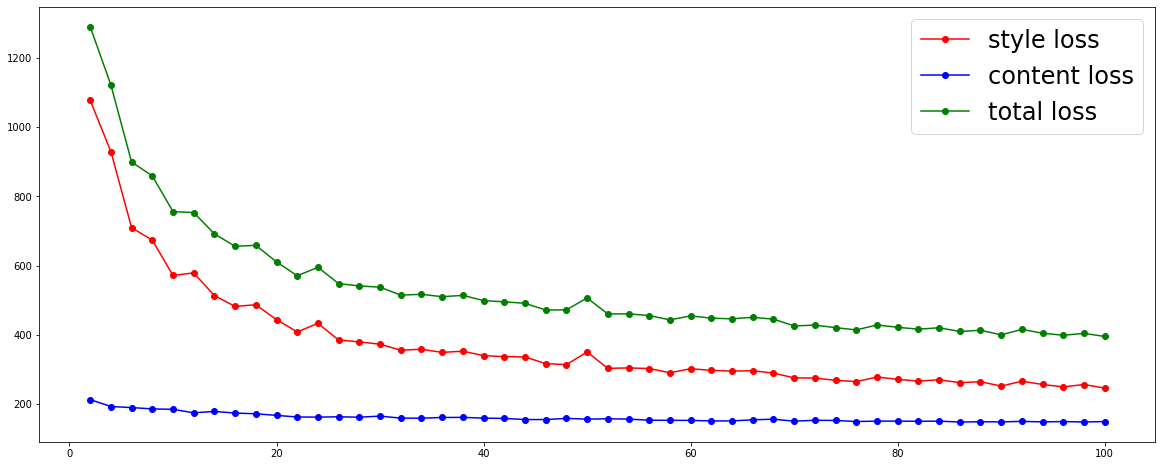

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
n_iters = list(range(2, 102, 2))

with PdfPages('loss_plots.pdf') as pdf:
  plt.figure(figsize=(20, 8),facecolor='white')
  plt.plot(n_iters, loss_style_list, label = 'style loss', linestyle='-', 
            color='red',marker='o')
  plt.plot(n_iters, loss_content_list, label = 'content loss', linestyle='-', 
            color='blue',marker='o')
  plt.plot(n_iters, loss_list, label = 'total loss', linestyle='-', 
            color='green',marker='o')
  plt.legend(prop={'size': 24})
  # plt.xlabel('number of training iterations passed, 1000')
  # plt.ylabel('loss value')
  pdf.savefig(dpi=1200, bbox_inches="tight")

# New Section